In [1]:
import pandas as pd
url="https://bd29ee0e-54ab-4daa-9671-d153865d1620.usrfiles.com/ugd/bd29ee_48dabd0418de4b87b9dcd91fe820c164.csv"
df=pd.read_csv(url,header=None)
df.head()

,0,1,2,3,4
0,6,0,66,50,1
1,6,1,70,50,2
2,6,0,69,50,3
3,6,0,68,50,4
4,6,0,67,50,5


In [2]:
df=df.drop(columns=[0,4])
df.head()

,1,2,3
0,0,66,50
1,1,70,50
2,0,69,50
3,0,68,50
4,0,67,50


In [3]:
df=df.rename(columns={1:"Stressed_o_ring",2:"Temperature",3:"Pressure"})
df.head()

,Stressed_o_ring,Temperature,Pressure
0,0,66,50
1,1,70,50
2,0,69,50
3,0,68,50
4,0,67,50


In [4]:
y=df[["Stressed_o_ring"]]

In [5]:
X=df.drop(["Stressed_o_ring"],axis=1)

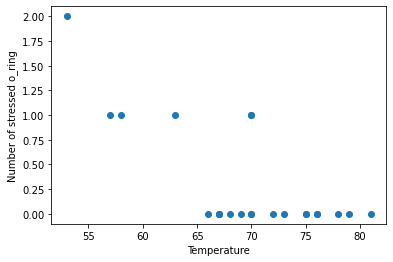

In [6]:
import matplotlib.pyplot as plt
temperature=X[["Temperature"]]
plt.scatter(temperature,y)
plt.xlabel("Temperature")
plt.ylabel("Number of stressed o_ring")
plt.show()

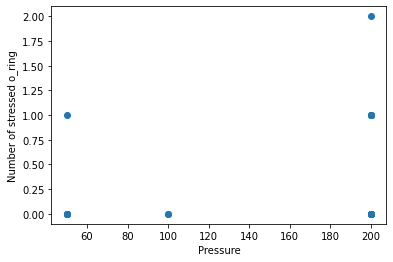

In [7]:
pressure=X[["Pressure"]]
plt.scatter(pressure,y)
plt.xlabel("Pressure")
plt.ylabel("Number of stressed o_ring")
plt.show()

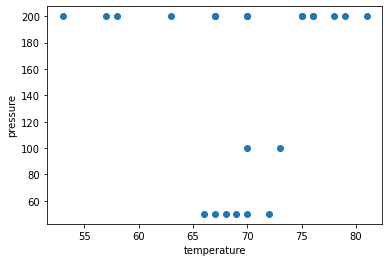

In [8]:
plt.scatter(temperature,pressure)
plt.xlabel("temperature")
plt.ylabel("pressure")
plt.show()

There is no clear relation between pressure and the  number of stresse o_ring. There is also no clear relation between temperature and pressure. However, there is clearly a relation between temperature and the number of stressed o_ring: the first scatter plot shows that the likelihood of o_ring failure increased as temperature dropped.

### I. Regression task

In [9]:
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [10]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression(n_jobs=-1).fit(temperature,y)
scores=cross_val_score(LR,temperature,np.asarray(y).reshape(y.shape[0],),scoring="neg_mean_absolute_error",cv=4)
print("Mean absolute error (MAE): ",-scores.mean(),"+/-",scores.std())

Mean absolute error (MAE):  0.31751307629936576 +/- 0.1330209015691812


In [11]:
#y_predLR = cross_val_predict(LR, temperature,np.asarray(y).reshape(y.shape[0],), cv=4)
y_predLR=pd.DataFrame(np.around(LR.predict(temperature),0),columns=["Predicted stressed o_ring"])

In [12]:
from sklearn.metrics import r2_score
print("R-squared: ",r2_score(y,y_predLR))

R-squared:  0.4177215189873419


Temperature alone explained about 42% of the change in the number of O_ring that would experience thermal stress. Let's see how much of the change in the number of O_ring could be explained by the combined changes in temperature and pressure.

In [13]:
LRX=LinearRegression(n_jobs=-1).fit(X,y)
scores=cross_val_score(LRX,X,np.asarray(y).reshape(y.shape[0],),scoring="neg_mean_absolute_error",cv=4)
print("Mean absolute error (MAE): ",-scores.mean(),"+/-",scores.std())

Mean absolute error (MAE):  0.25378189197209844 +/- 0.12939428343993895


In [14]:
y_predLRX=pd.DataFrame(np.around(LRX.predict(X),0),columns=["Predicted stressed o_ring"])

print("R-squared: ",r2_score(y,y_predLRX))

R-squared:  0.27215189873417733


Including "pressure" does not improve R-squared. For the rest of this analysis, I will use only "temperature". As the first scatter plot above shows, there is clearly a relation between the number of stressed O_ring and temperature.

Let's make up some temperatures that include the forecast launch date temperature and have the Linear regression model predict the number of stressed O_ring under these temperatures.

In [15]:
temp=np.arange(30,53)
temp=pd.DataFrame(temp,columns=["Temperature"])
len(temp)

23

In [16]:
#y_predLR=pd.DataFrame(np.around(y_predLR,0),columns=["Predicted stressed o_ring"])

In [17]:
y_predLR2=pd.DataFrame(np.around(LR.predict(temp),0),columns=["Predicted stressed o_ring"])

In [18]:
y_predLR3=pd.concat([y_predLR2,y_predLR],axis=0)

In [19]:
temp2=pd.concat([temp,temperature],axis=0)

In [20]:
predictions=pd.concat([temp2,y_predLR3],axis=1)
predictions

,Temperature,Predicted stressed o_ring
0,30,3.0
1,31,3.0
2,32,2.0
3,33,2.0
4,34,2.0
5,35,2.0
6,36,2.0
7,37,2.0
8,38,2.0
9,39,2.0


If the temperature dropped to the forecast temperature, which was 31 F, as many as 3 o_rings would experience thermal stress.

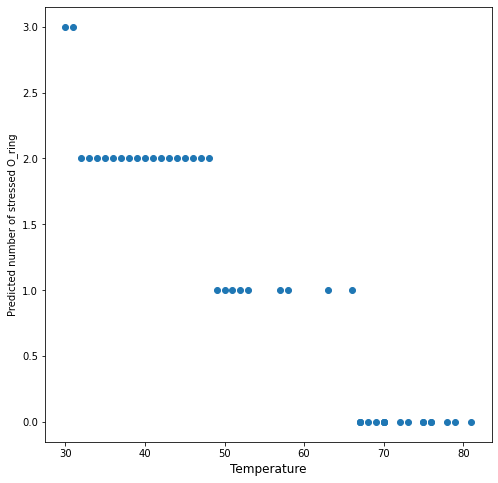

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(predictions["Temperature"],predictions["Predicted stressed o_ring"])
plt.xlabel("Temperature",fontsize=12)
plt.ylabel("Predicted number of stressed O_ring")
plt.show()

In [22]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [23]:
PR=make_pipeline(PolynomialFeatures(degree=4), Ridge()).fit(temperature,y)
scores=cross_val_score(PR,temperature,np.asarray(y).reshape(y.shape[0],),scoring="neg_mean_absolute_error",cv=3)
print("Mean absolute error (MAE): ",-scores.mean(),"+/-",scores.std())

Mean absolute error (MAE):  0.23889058524290543 +/- 0.06768440671100409


In [24]:
y_predPR=pd.DataFrame(np.around(PR.predict(temperature),0),columns=["Predicted stressed o_ring"])

In [25]:
print("R-squared: ",r2_score(y,y_predPR))

R-squared:  0.5632911392405064


In [26]:
y_predPR2=pd.DataFrame(np.around(PR.predict(temp),0),columns=["Predicted stressed o_ring"])

In [27]:
y_predPR3=pd.concat([y_predPR2,y_predPR],axis=0)

In [28]:
predictions=pd.concat([temp2,y_predPR3],axis=1)
predictions

,Temperature,Predicted stressed o_ring
0,30,11.0
1,31,11.0
2,32,10.0
3,33,10.0
4,34,9.0
5,35,8.0
6,36,8.0
7,37,8.0
8,38,7.0
9,39,7.0


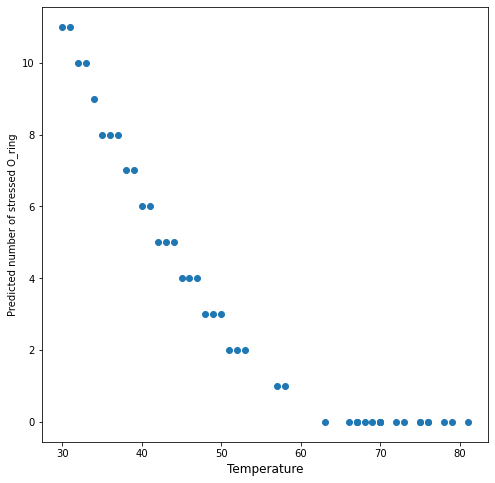

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(predictions["Temperature"],predictions["Predicted stressed o_ring"])
plt.xlabel("Temperature",fontsize=12)
plt.ylabel("Predicted number of stressed O_ring")
plt.show()

The polynomial regression gave an even more dire prediction if the launch temperature dropped to 31 degrees F. The linear regression predicted that 3 o_rings would fail. However, when tested on real data, the linear regression model did not catch the incident in the original data where the number of stresse o_ring was 2. The linear model predicted 1. That means the linear model underestimated the number of stressed o_ring.

On the contrary, when tested on real data, the polynomial model predicted that at 53 degrees F, there would be 2 stressed o_ring, which was what actually happened. Hence, the predictions by the polynomial  model is more accurate.

The polynomial model predicted that if the launch temperature dropped to the forecast temperature, which was 31 degrees F, 11 o_rings would experience thermal stress. There were 6 field joints in the spaceshuttle.  Each of these six field joints included two O-rings.In other words, there were 12 o_rings in total. The polynomial model predicted that 11 o_rings would experience thermal stress, that means all 6 fied joints on the Challenger spaceshuttle would fail if the launch date temperature dropped to the forecast 31 degrees F. **How could the engineers and engineering managers at NASA ignore this potential engineering catastrophe at pre-launch discussion?** The entire Challenger crew was killed.

### II. Classification task

In [30]:
y=y.replace(2,1)
np.unique(y)

array([0, 1])

In [31]:
from sklearn import svm
SVM=svm.SVC(C=6,kernel="poly",probability=True).fit(temperature,np.asarray(y).reshape(y.shape[0],))
scores=cross_val_score(SVM,temperature,np.asarray(y).reshape(y.shape[0],),cv=6)
print("Accuracy ",scores.mean(),"+/-",scores.std())

Accuracy  0.875 +/- 0.125


In [32]:
y_predSVM = cross_val_predict(SVM, temperature,np.asarray(y).reshape(y.shape[0],), cv=6)

In [33]:
from sklearn.metrics import roc_auc_score
print("ROC_AUC: ",roc_auc_score(y,y_predSVM))

ROC_AUC:  0.75


In [34]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n",confusion_matrix(y,y_predSVM))

Confusion matrix: 
 [[17  0]
 [ 3  3]]


In [35]:
y_predSVM1=pd.DataFrame(SVM.predict_proba(temperature),columns={0:"Pred_0",1:"Pred_1"})

y_predSVM2=pd.DataFrame(SVM.predict_proba(temp),columns={0:"Pred_0",1:"Pred_1"})

y_predSVM3=pd.concat([y_predSVM2,y_predSVM1],axis=0)

predictions=pd.concat([temp2,y_predSVM3],axis=1).rename(columns={0:"Probability: no failure",1: "Probability: failure"})

predictions.head(10)

,Temperature,Probability: no failure,Probability: failure
0,30,0.171408,0.828592
1,31,0.175060,0.824940
2,32,0.179023,0.820977
3,33,0.183317,0.816683
4,34,0.187966,0.812034
5,35,0.192995,0.807005
6,36,0.198429,0.801571
7,37,0.204297,0.795703
8,38,0.210629,0.789371
9,39,0.217456,0.782544


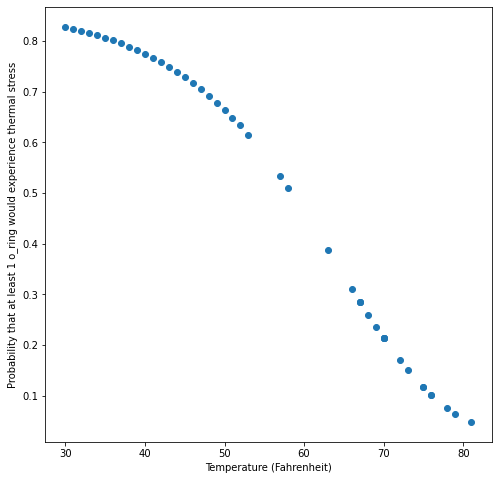

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(predictions["Temperature"],predictions["Probability: failure"])
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Probability that at least 1 o_ring would experience thermal stress")
plt.show()

In [37]:
from sklearn.naive_bayes import GaussianNB
Gaussian=GaussianNB().fit(temperature,np.asarray(y).reshape(y.shape[0],))
scores=cross_val_score(Gaussian,temperature,np.asarray(y).reshape(y.shape[0],),cv=5)
print("Accuracy ",scores.mean(),"+/-",scores.std())

Accuracy  0.9199999999999999 +/- 0.09797958971132709


In [38]:
y_predGaussian= cross_val_predict(Gaussian, temperature,np.asarray(y).reshape(y.shape[0],), cv=5)

In [39]:
from sklearn.metrics import roc_auc_score
print("ROC_AUC: ",roc_auc_score(y,y_predGaussian))

ROC_AUC:  0.8333333333333333


In [40]:
print("Confusion matrix: \n",confusion_matrix(y,y_predGaussian))

Confusion matrix: 
 [[17  0]
 [ 2  4]]


In [41]:
y_predGaussian1=pd.DataFrame(Gaussian.predict_proba(temperature),columns={0:"Pred_0",1:"Pred_1"})

y_predGaussian2=pd.DataFrame(Gaussian.predict_proba(temp),columns={0:"Pred_0",1:"Pred_1"})

y_predGaussian3=pd.concat([y_predGaussian2,y_predGaussian1],axis=0)

predictions=pd.concat([temp2,y_predGaussian3],axis=1).rename(columns={0:"Probability: no failure",1: "Probability: failure"})

predictions.head(10)

,Temperature,Probability: no failure,Probability: failure
0,30,3.142628e-13,1.0
1,31,1.071615e-12,1.0
2,32,3.569751e-12,1.0
3,33,1.161690e-11,1.0
4,34,3.693141e-11,1.0
5,35,1.146977e-10,1.0
6,36,3.479901e-10,1.0
7,37,1.031412e-09,1.0
8,38,2.986419e-09,1.0
9,39,8.447392e-09,1.0


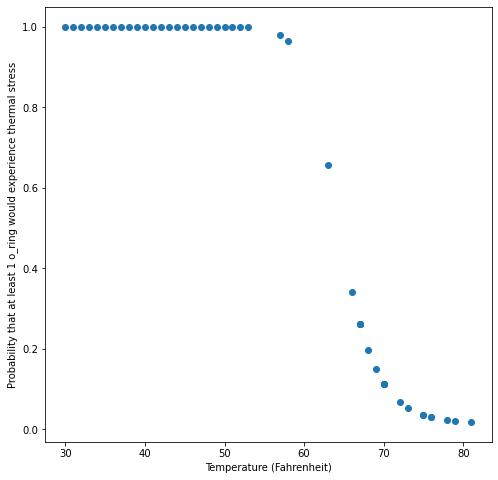

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(predictions["Temperature"],predictions["Probability: failure"])
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Probability that at least 1 o_ring would experience thermal stress")
plt.show()

If the temperature dropped to the forecast 31 degrees F, the Support Vector Machine model predicted that the probability that at least 1 o_ring on the spaceshuttle would experience thermal stress was 89.2%. The Gaussian Naive Bayes model, which was more accurate in its classification capability, predicted that at 31 degrees F, the probability that at least 1 O_ring would experience thermal stress is 100%. **It is VERY clear that the temperature dropped, the probability of o_ring failure increased. Again, how could the engineers and engineering managers at NASA ignore a risk probability that was at least 89.2%?** The entire Challenger crew was killed.

### Summary

#### If the launch date temperature dropped to the forecast 31 degrees F, 

####  Linear regression model: Three O_rings would experience thermal stress.That means, two of the six field joints would fail. (However, the linear model tended to underestimate.)
####  Polynomial regression model: As many as 11 O_rings would experience thermal stress. That means, all six field joints on the spaceshuttle would fail.
#### Support Vector Machine classification model: The probability that at least 1 O_ring would experience thermal stress was 89.2%. Almost a certainty. 
#### Gaussian Naive Bayes classificaiton model (more accurate than the SVM model): The probability that at least 1 O_ring would experience thermal stress was 100%.

### Conclusion: The explosion of the Challenger space shuttle was a NASA engineering failure that could have been avoided. In rushing to launch the Challenger space shuttle, NASA sent the crew to their graves, not the space.

**<span style="color:red">If I had a family member on the Challenger, I would hate NASA for the rest of my life. I sure would.</span>**

#### Regression model

|Model|R-squared|Mean Absolute Error (MAE)|Standard deviation|Predicted number of O_ring incident at 31 F|
|-----|---------|-------------------------|------------------|-----------------------|
|Linear model with both "temperature" and "pressure"|0.2722|0.2538|0.1294|N/A|
|Linear model with "temperature"|0.4177|0.3175|0.1330|3|
|Polynomial model with "temperature|0.5633|0.2389|0.0677|11|

#### Binary classification model

|Model|Accuracy|AUC|Predicted probability of at least 1 O_ring incident at 31 F|
|-----|--------|----|-----------------------------------------------------------|
|Support Vector Machine|87.5%|0.75|89.2%|
|Gaussian Naive Bayes|92%|0.83|100%|